In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np

## Data Preparation

In [2]:
dataset = pd.read_excel('../input/covid19/covid19-dataset.xlsx', index_col=0)

### Replace column values that should be empty for NaN

In [3]:
dataset['Urine - pH'].replace('Não Realizado', np.nan, inplace=True)

In [4]:
dataset['Urine - pH'] = dataset['Urine - pH'].astype('float64')

In [5]:
dataset.replace('not_done', np.nan, inplace=True)

### Replace Leukocytes' values '<1000' for 999

In [6]:
dataset['Urine - Leukocytes'].replace('<1000', '999', inplace=True)
dataset['Urine - Leukocytes'] = dataset['Urine - Leukocytes'].astype('float64')

### Replace True and False values for 0 and 1

In [7]:
dataset.replace('not_detected', 0, inplace=True)
dataset.replace('detected', 0, inplace=True)
dataset.replace('negative', 0, inplace=True)
dataset.replace('positive', 1, inplace=True)
dataset.replace('absent', 0, inplace=True)
dataset.replace('present', 1, inplace=True)

### Label Encoding

In [8]:
df_temp = dataset[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']].astype("str").apply(LabelEncoder().fit_transform)
dataset[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']] = df_temp.where(~dataset[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']].isna(), dataset[['Urine - Aspect', 'Urine - Urobilinogen', 'Urine - Crystals', 'Urine - Color']])

In [9]:
dataset['Urine - Aspect'] = dataset['Urine - Aspect'].astype("float64")
dataset['Urine - Urobilinogen'] = dataset['Urine - Urobilinogen'].astype("float64")
dataset['Urine - Crystals'] = dataset['Urine - Crystals'].astype("float64")
dataset['Urine - Color'] = dataset['Urine - Color'].astype("float64")

### Drop unnecessary columns

In [10]:
dataset.drop(columns=['Patient addmited to regular ward (1=yes, 0=no)',
                      'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                      'Patient addmited to intensive care unit (1=yes, 0=no)'], inplace=True)

## Analysis of missing data

In [11]:
def plot_missing_data(missing_data, title):
    f, ax = plt.subplots(figsize=(15, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=missing_data.index, y=missing_data['Percent'])
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title(title, fontsize=15)

In [12]:
def get_missing_data(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

,Total,Percent
Mycoplasma pneumoniae,5644,1.000000
Urine - Nitrite,5644,1.000000
Urine - Sugar,5644,1.000000
Partial thromboplastin time (PTT),5644,1.000000
"Prothrombin time (PT), Activity",5644,1.000000
D-Dimer,5644,1.000000
Fio2 (venous blood gas analysis),5643,0.999823
Vitamin B12,5641,0.999468
Lipase dosage,5636,0.998583
Albumin,5631,0.997697


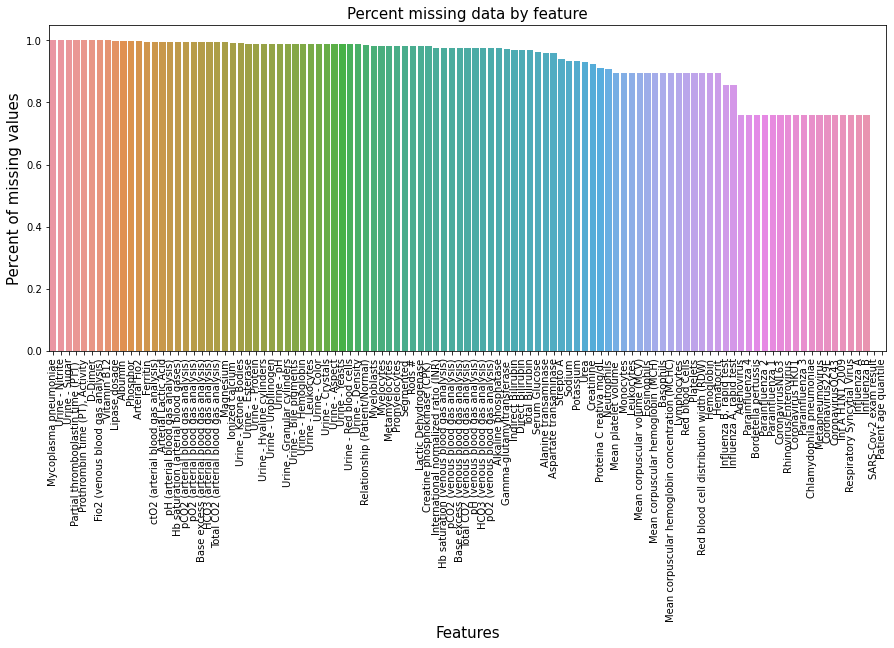

In [13]:
missing_data = get_missing_data(dataset)
plot_missing_data(missing_data, 'Percent missing data by feature')
missing_data.head(10)

,Total,Percent
Fio2 (venous blood gas analysis),558,1.000000
D-Dimer,558,1.000000
Urine - Nitrite,558,1.000000
Partial thromboplastin time (PTT),558,1.000000
"Prothrombin time (PT), Activity",558,1.000000
Vitamin B12,558,1.000000
Mycoplasma pneumoniae,558,1.000000
Urine - Sugar,558,1.000000
Albumin,558,1.000000
Phosphor,557,0.998208


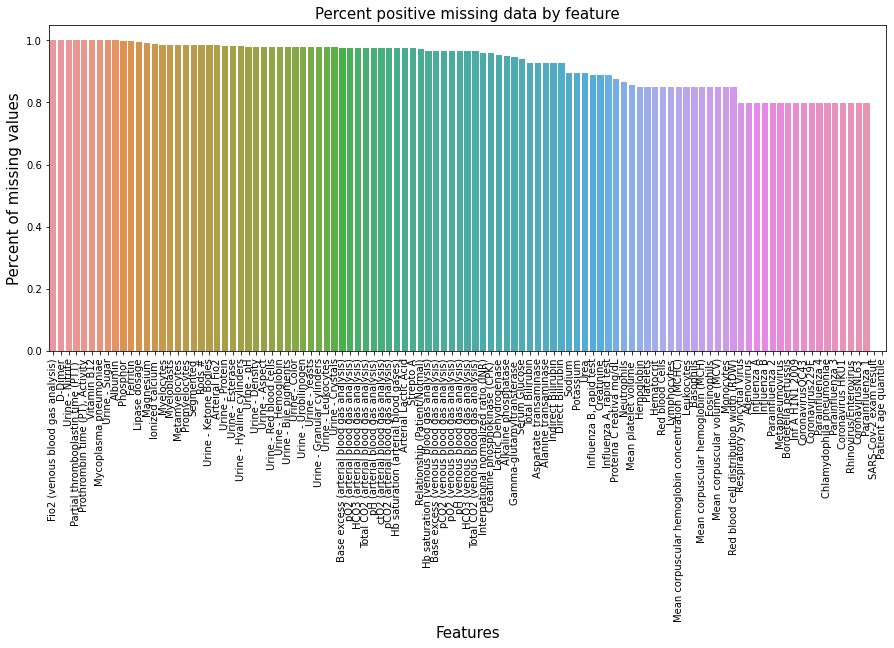

In [14]:
dataset_positive = dataset[dataset['SARS-Cov-2 exam result'] == 1]
missing_data_positive = get_missing_data(dataset_positive)

plot_missing_data(missing_data_positive, 'Percent positive missing data by feature')
missing_data_positive.head(10)

,Total,Percent
Urine - Sugar,5086,1.000000
Partial thromboplastin time (PTT),5086,1.000000
Urine - Nitrite,5086,1.000000
"Prothrombin time (PT), Activity",5086,1.000000
Mycoplasma pneumoniae,5086,1.000000
D-Dimer,5086,1.000000
Fio2 (venous blood gas analysis),5085,0.999803
Vitamin B12,5083,0.999410
Lipase dosage,5081,0.999017
Arteiral Fio2,5075,0.997837


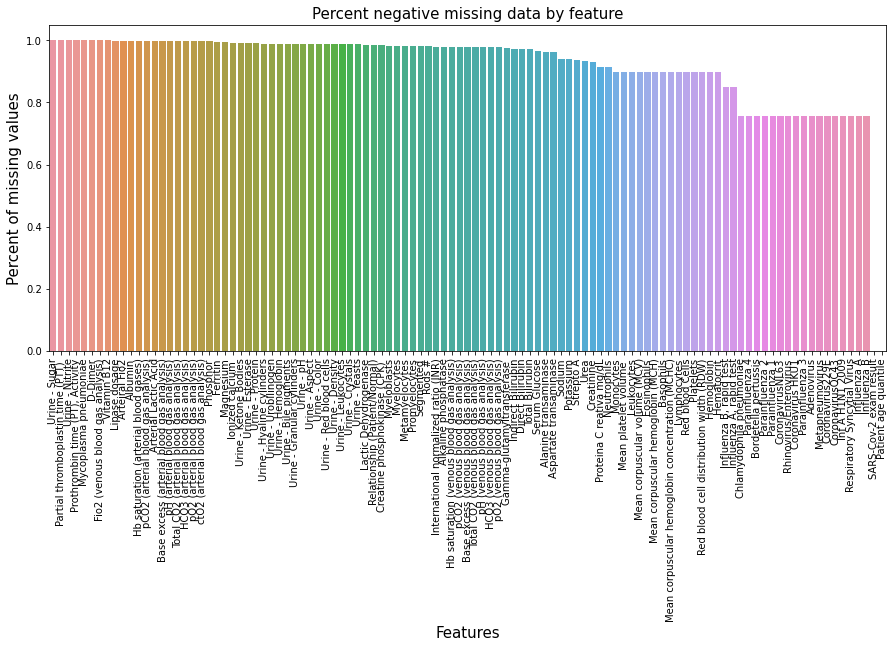

In [15]:
dataset_negative = dataset[dataset['SARS-Cov-2 exam result'] == 0]
missing_data_negative = get_missing_data(dataset_negative)

plot_missing_data(missing_data_negative, 'Percent negative missing data by feature')
missing_data_negative.head(10)

## Correlation Vector

In [16]:
corrmat = abs(dataset.corr())

In [17]:
# Correlation with output variable
cor_target = corrmat["SARS-Cov-2 exam result"]
# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15].index.tolist()

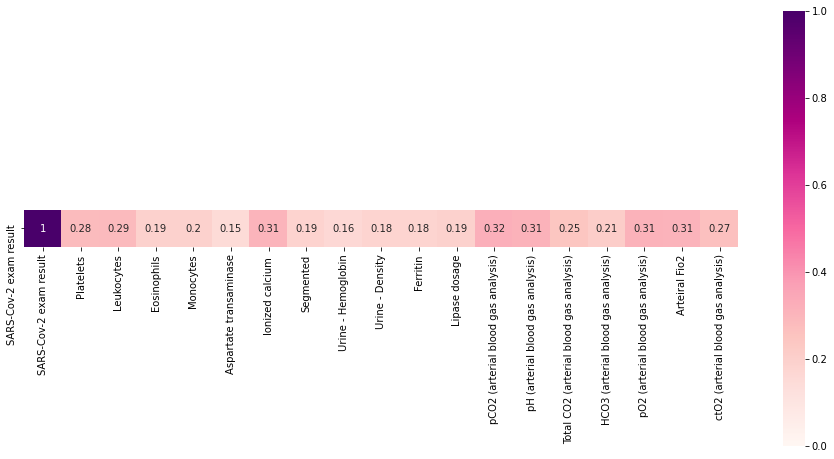

In [18]:
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(abs(dataset[relevant_features].corr().iloc[0:1, :]), yticklabels=[relevant_features[0]], xticklabels=relevant_features, vmin = 0.0, square=True, annot=True, vmax=1.0, cmap='RdPu')

## Negative and Positive Cases

In [19]:
nof_positive_cases = len(dataset_positive.index)
nof_negative_cases = len(dataset_negative.index)

(-1.1076132200227402,
 1.106918589509273,
 -1.1043893148273538,
 1.1002090207918012)

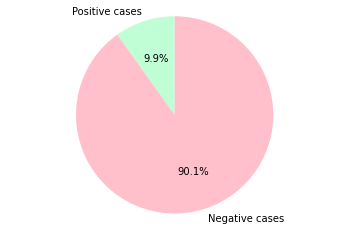

In [20]:
fig1, ax1 = plt.subplots()
ax1.pie([nof_positive_cases, nof_negative_cases], labels=['Positive cases', 'Negative cases'], autopct='%1.1f%%', startangle=90, colors=['#c0ffd5', '#ffc0cb'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

## Dealing with missing values and imbalanced data

First of all, we chose to drop the features with more than 99,8% of NaN values in positive cases, since we don't believe they'll help to predict COVID-19.

In [21]:
columns_to_exclude = missing_data_positive.index[missing_data_positive['Percent'] > 0.998].tolist()
dataset.drop(columns=columns_to_exclude, inplace=True)
print(columns_to_exclude)

['Fio2 (venous blood gas analysis)', 'D-Dimer', 'Urine - Nitrite', 'Partial thromboplastin time\xa0(PTT)\xa0', 'Prothrombin time (PT), Activity', 'Vitamin B12', 'Mycoplasma pneumoniae', 'Urine - Sugar', 'Albumin', 'Phosphor']


In [22]:
# Redefine dataset positive and negative
dataset_negative = dataset[dataset['SARS-Cov-2 exam result'] == 0]
dataset_positive = dataset[dataset['SARS-Cov-2 exam result'] == 1]

As can be seen from the pie chart above, the dataset is highly imbalanced. We tried to train some models with the imbalanced data, but the results achieved were around 6% of recall. Then, in order to balance the dataset we chose to keep only the rows with at least 20 non-NaN values.

In [23]:
dataset_negative = dataset_negative.dropna(axis=0, thresh=20)

### Negative and Positive cases

Below, we can see the percentage of negative and positive cases after under-sampling.

In [24]:
X = pd.concat([dataset_negative, dataset_positive])

In [25]:
nof_positive_cases = len(dataset_positive.index)
nof_negative_cases = len(dataset_negative.index)

(-1.1275371457422187,
 1.111868446375018,
 -1.1088271473097018,
 1.100420340348081)

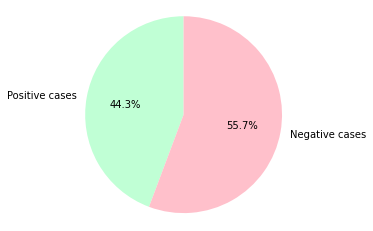

In [26]:
fig1, ax1 = plt.subplots()
ax1.pie([nof_positive_cases, nof_negative_cases], labels=['Positive cases', 'Negative cases'], autopct='%1.1f%%', startangle=90, colors=['#c0ffd5', '#ffc0cb'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

### Correlation Vector

In [27]:
corrmat = abs(X.corr())

In [28]:
# Correlation with output variable
cor_target = corrmat["SARS-Cov-2 exam result"]
# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15].index.tolist()

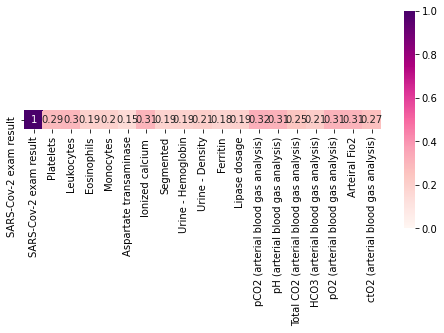

In [29]:
f, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(abs(X[relevant_features].corr().iloc[0:1, :]), yticklabels=[relevant_features[0]], xticklabels=relevant_features, vmin = 0.0, square=True, annot=True, vmax=1.0, cmap='RdPu')

## Training Binary Classifier of COVID-19

### Define features and target

We tried to use two approaches, the first consisted in using only the revelant features to train our models.

In [30]:
X_with_relevant_features = X[relevant_features]
y_with_relevant_features = X_with_relevant_features['SARS-Cov-2 exam result']
X_with_relevant_features.drop(columns=['SARS-Cov-2 exam result'], inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The second consisted in using all of the features to train our models.

In [31]:
y = X['SARS-Cov-2 exam result']
X.drop(columns=['SARS-Cov-2 exam result'], inplace=True)

### Metrics Choice

The chosen metrics to train our models were:

- Recall, because we wanted to measure the proportion of actual positive cases of COVID-19 identified correctly;
- AUC, because we wanted to measure the probability that the model ranks a random positive case of COVID-19 more highly than a random negative COVID-19 case.

We believe that the goal is to avoid as many false negatives as possible, because a false negative would mean a patient wrongfully diagnosed could infect others. We're also going to share scores as accuracy and precision for informational reasons.

In [32]:
def print_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Precision: %.2f%% " % (precision * 100))
    print("Recall: %.2f%% " % (recall * 100))
    print("AUC: %.2f%% " % (roc * 100))

In [33]:
def plot_confusion_matrix(y_test, y_pred):
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, cmap='RdPu')

### Random Forest Classifier

First we split the dataset into train and test set, in a proportion of 80:20.

In [34]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_with_relevant_features, y_with_relevant_features, test_size=0.2, random_state=42)

In [35]:
print("Number of samples in train set: %d" % y_train_rf.shape)
print("Number of positive samples in train set: %d" % (y_train_rf == 1).sum(axis=0))
print("Number of negative samples in train set: %d" % (y_train_rf == 0).sum(axis=0))
print()
print("Number of samples in test set: %d" % y_test_rf.shape)
print("Number of positive samples in test set: %d" % (y_test_rf == 1).sum(axis=0))
print("Number of negative samples in test set: %d" % (y_test_rf == 0).sum(axis=0))

Number of samples in train set: 1008
Number of positive samples in train set: 452
Number of negative samples in train set: 556

Number of samples in test set: 252
Number of positive samples in test set: 106
Number of negative samples in test set: 146


Then, we imput the median values into the NaN values.

In [36]:
imp = SimpleImputer(strategy='median')
imp = imp.fit(X_with_relevant_features)

Finally, we trained the random forest classifier using 10-fold cross validation, in order to avoid overfitting, and grid search, in order to tune hyperparameters.

In [37]:
rfc = RandomForestClassifier()

# Define parameters and grid search
n_estimators = [100, 300, 500, 800, 1000]
max_depth = [5, 8, 15, 25, 30]
grid = dict(n_estimators=n_estimators, max_depth=max_depth)
grid_search = GridSearchCV(estimator=rfc, param_grid=grid, n_jobs=-1, cv=10, scoring='recall', error_score=0)
grid_result = grid_search.fit(imp.transform(X_train_rf), y_train_rf)
print("Best recall: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best recall: 0.895990 using {'max_depth': 15, 'n_estimators': 500}


In [38]:
rfc.n_estimators = grid_result.best_params_['n_estimators']
rfc.max_depth = grid_result.best_params_['max_depth']
                                   
model_rfc = rfc.fit(imp.transform(X_train_rf), y_train_rf)

In [39]:
y_pred_rf = model_rfc.predict(imp.transform(X_test_rf))
print_scores(y_test_rf, y_pred_rf)

Accuracy: 76.98%
Precision: 66.22% 
Recall: 92.45% 
AUC: 79.10% 


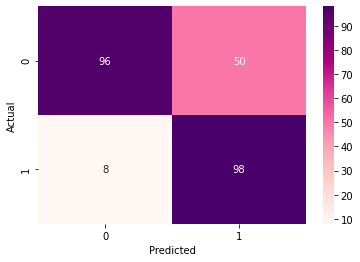

In [40]:
plot_confusion_matrix(y_test_rf, y_pred_rf)

### XGBoost Classifier

First we split the dataset into train, validation and test set in a proportion of 70:15:15.

In [41]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
X_test_xgb, X_validation_xgb, y_test_xgb, y_validation_xgb = train_test_split(X_test_xgb, y_test_xgb, test_size=0.5, random_state=42)

In [43]:
print("Number of samples in train set: %d" % y_train_xgb.shape)
print("Number of positive samples in train set: %d" % (y_train_xgb == 1).sum(axis=0))
print("Number of negative samples in train set: %d" % (y_train_xgb == 0).sum(axis=0))
print()
print("Number of samples in validation set: %d" % y_validation_xgb.shape)
print("Number of positive samples in validation set: %d" % (y_validation_xgb == 1).sum(axis=0))
print("Number of negative samples in validation set: %d" % (y_validation_xgb == 0).sum(axis=0))
print()
print("Number of samples in test set: %d" % y_test_rf.shape)
print("Number of positive samples in test set: %d" % (y_test_xgb == 1).sum(axis=0))
print("Number of negative samples in test set: %d" % (y_test_xgb == 0).sum(axis=0))

Number of samples in train set: 882
Number of positive samples in train set: 398
Number of negative samples in train set: 484

Number of samples in validation set: 189
Number of positive samples in validation set: 83
Number of negative samples in validation set: 106

Number of samples in test set: 252
Number of positive samples in test set: 77
Number of negative samples in test set: 112


Then, we trained the XGBoost Classifier 

In [44]:
model_xgb = XGBClassifier()

# Define parameters and grid search
n_estimators = [100, 300, 500, 700]
subsample = [0.5, 0.7, 1.0]
max_depth = [6, 7, 9]
grid = dict(n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
grid_search = GridSearchCV(estimator=model_xgb, param_grid=grid, n_jobs=-1, cv=10, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_xgb, y_train_xgb)
print("Best AUC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best AUC: 0.976165 using {'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}


In [45]:
model_xgb.n_estimators = grid_result.best_params_['n_estimators']
model_xgb.subsample = grid_result.best_params_['subsample']
model_xgb.max_depth = grid_result.best_params_['max_depth']

In [46]:
model_xgb.fit(X_train_xgb, y_train_xgb, eval_metric='auc', eval_set=[(X_train_xgb, y_train_xgb), (X_validation_xgb, y_validation_xgb)], verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=None)

Finally, our results evaluated for validation set.

In [47]:
val_predictions_xgb = model_xgb.predict(X_validation_xgb)
print_scores(y_validation_xgb, val_predictions_xgb)

Accuracy: 94.71%
Precision: 93.98% 
Recall: 93.98% 
AUC: 94.63% 


And our results evaluated for test set, along with the confusion matrix, feature importances and ROC curve.

In [48]:
predictions_xgb = model_xgb.predict(X_test_xgb)
print_scores(y_test_xgb, predictions_xgb)

Accuracy: 95.77%
Precision: 96.00% 
Recall: 93.51% 
AUC: 95.41% 


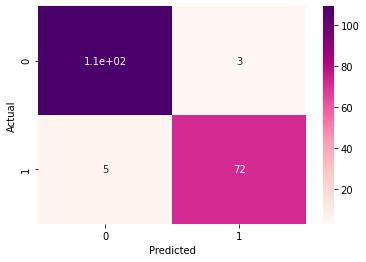

In [49]:
plot_confusion_matrix(y_test_xgb, predictions_xgb)

In [50]:
feature_importances = model_xgb.get_booster().get_fscore()
feature_importances_df = pd.DataFrame({'Feature Score': list(feature_importances.values()), 'Features': list(feature_importances.keys())})
feature_importances_df.sort_values(by='Feature Score', ascending=False, inplace=True)
feature_importances_df = feature_importances_df.head(15)

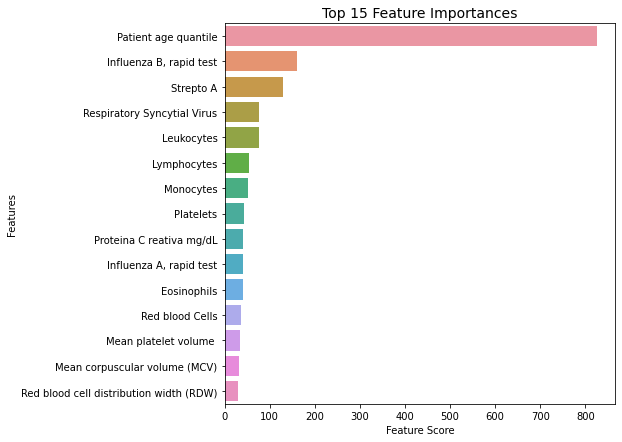

In [51]:
f, ax = plt.subplots(figsize=(7, 7))
plt.title('Top 15 Feature Importances', fontsize=14)
sns.barplot(x=feature_importances_df['Feature Score'], y=feature_importances_df['Features'])

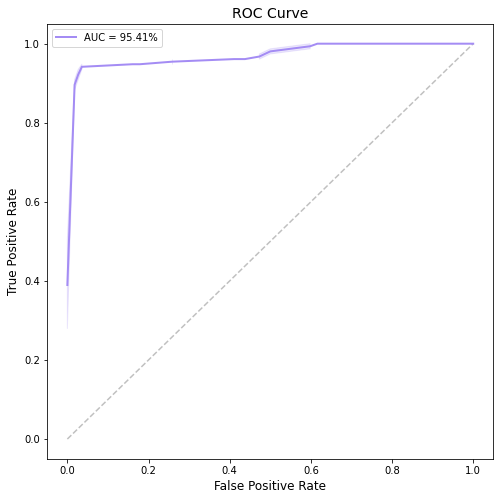

In [52]:
f, ax = plt.subplots(figsize=(8, 8))
plt.plot([0, 1], [0, 1], '--', color='silver')
plt.title('ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
fpr, tpr, thresholds = roc_curve(y_test_xgb, model_xgb.predict_proba(X_test_xgb)[:,1]) 
sns.lineplot(x=fpr, y=tpr, color=sns.color_palette("husl", 8)[-2], linewidth=2, label="AUC = 95.41%")

## COVID-19 Classifiers with AUC 95.41%, Recall 93.51%